### Training Data on CatBoost model

In [31]:
# Import necessary libraries
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

First, we load the dataset

In [16]:
# Load the train dataset
data = pd.read_csv('./data/train-set/data_sklearn_models.csv')
data.head(5)

,storey_range,resale_price,town_BEDOK,town_BISHAN,town_BUKIT BATOK,town_BUKIT MERAH,town_BUKIT PANJANG,town_BUKIT TIMAH,town_CENTRAL AREA,town_CHOA CHU KANG,...,flat_model_Standard,flat_model_Terrace,flat_model_Type S1,flat_model_Type S2,floor_area_sqm,remaining_lease,sora,bto_supply_within_4km,distance2cbd,poi_vector_average
0,2,12.449019,0,0,0,0,0,0,0,0,...,0,0,0,0,-1.546558,-0.345484,-0.802967,-0.833389,-0.524994,-0.375705
1,0,12.524526,0,0,0,0,0,0,0,0,...,0,0,0,0,-1.213944,-0.727997,-0.802967,-0.167970,-0.582020,0.258150
2,0,12.560244,0,0,0,0,0,0,0,0,...,0,0,0,0,-1.172367,-0.804500,-0.802967,-0.899113,-0.565965,-0.375705
3,0,12.577636,0,0,0,0,0,0,0,0,...,0,0,0,0,-1.213944,-0.881003,-0.802967,-0.296103,-0.738546,-0.133931
4,2,12.577636,0,0,0,0,0,0,0,0,...,0,0,0,0,-1.213944,-0.804500,-0.802967,-0.044030,-0.637076,0.258150


In [17]:
# Split the data into features and target
X = data.drop('resale_price', axis=1)
y = data['resale_price']

### Validation Set (K-Fold)

- We create a CatBoostRegressor object and a KFold object for 5-fold cross-validation.
- We use cross_val_score to perform cross-validation on the CatBoost model, specifying the scoring metric as the negative mean squared error ('neg_mean_squared_error').
- Finally, we print the average cross-validation score, which is the negative mean squared error averaged across all folds.

In [34]:
from sklearn.model_selection import KFold, cross_val_score

# Create a CatBoost regressor object
cat_model = CatBoostRegressor(verbose=False)

# Create a KFold object for 5-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation and calculate the negative mean squared error
scores = cross_val_score(cat_model, X, y, cv=kfold, scoring='neg_mean_absolute_error')

# Print the average cross-validation score
print(f"Average Cross-Validation Score: {-scores.mean():.2f}") #0.05

Average Cross-Validation Score: 0.05


Hyper-Param Tuning (Using Grid Search)

In [18]:
# Train the CatBoost model on the training dataset
cat_model = CatBoostRegressor(verbose=False)
cat_model.fit(X, y)


In [32]:
from sklearn.model_selection import GridSearchCV

#from above: X, y
X = data.drop('resale_price', axis=1)
y = data['resale_price']

# Define the hyperparameter grid
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5],
    'bagging_temperature': [0.2, 0.5, 0.8]
}

# Create a CatBoost regressor object
cat_model = CatBoostRegressor(verbose=False)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=cat_model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           n_jobs=-1,
                           verbose=1)

# Perform grid search
grid_search.fit(X, y)

# Print the best hyperparameters and the corresponding score
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", -grid_search.best_score_)

# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_

# Load the test dataset
test_data = pd.read_csv('2024-data.csv')

# Split the test data into features and target
X_test = test_data.drop('resale_price', axis=1)
y_test = test_data['resale_price']


y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Hyperparameters:  {'bagging_temperature': 0.2, 'depth': 8, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
Best Score:  0.025089363211115122
Mean Absolute Error: 0.05
Mean Squared Error: 0.00
R-squared: 0.95


In [38]:
# Load the test dataset
test_data = pd.read_csv('2024-data.csv')

# Split the test data into features and target
X_test = test_data.drop('resale_price', axis=1)
y_test = test_data['resale_price']

# Make predictions on the test set
y_pred = cat_model.predict(X_test)

[12.56706557 12.53470229 13.11222607 ... 13.33921665 13.61562109
 13.58271757]


### Visualisation: Model Performance Metrics Bar Chart

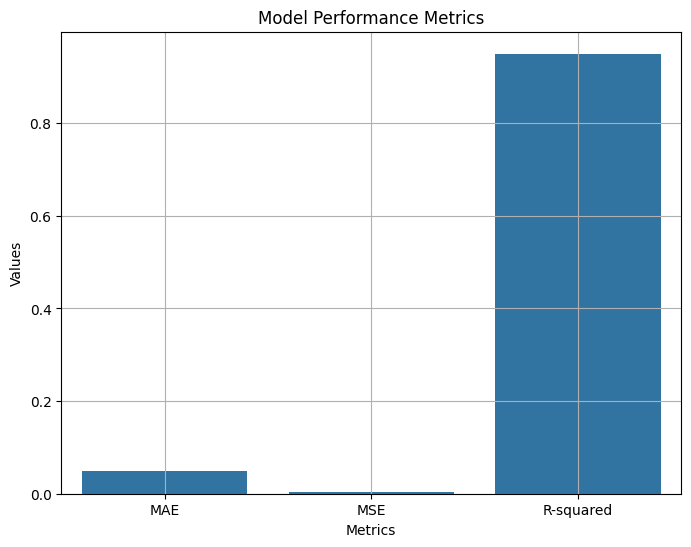

In [49]:
metrics = ['MAE', 'MSE', 'R-squared']
values = [mae, mse, r2]

plt.figure(figsize=(8, 6))
sns.barplot(x=metrics, y=values)
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.title("Model Performance Metrics")
plt.grid(True)
plt.show()

Prediction for single entry

In [46]:
# Defined a sample single entry for which you want to make a prediction
single_entry = {'storey_range': 0,
                'town_BEDOK': 0,
                'town_BISHAN': 0,
                'town_BUKIT BATOK': 0,
                'town_BUKIT MERAH': 1,
                'town_BUKIT PANJANG': 0,
                'town_BUKIT TIMAH': 0,
                'town_CENTRAL AREA': 0,
                'town_CHOA CHU KANG': 0,
                'town_CLEMENTI': 0,
                'town_GEYLANG': 0,
                'town_HOUGANG': 0,
                'town_JURONG EAST': 0,
                'town_JURONG WEST': 0,
                'town_KALLANG/WHAMPOA': 0,
                'town_MARINE PARADE': 0,
                'town_PASIR RIS': 0,
                'town_PUNGGOL': 0,
                'town_QUEENSTOWN': 0,
                'town_SEMBAWANG': 0,
                'town_SENGKANG': 0,
                'town_SERANGOON': 0,
                'town_TAMPINES': 0,
                'town_TOA PAYOH': 0,
                'town_WOODLANDS': 0,
                'town_YISHUN': 0,
                'flat_model_Apartment': 0,
                'flat_model_DBSS': 0,
                'flat_model_Improved': 0,
                'flat_model_Maisonette': 0,
                'flat_model_Model A': 0,
                'flat_model_Model A2': 0,
                'flat_model_New Generation': 1,
                'flat_model_Others': 0,
                'flat_model_Premium Apartment': 0,
                'flat_model_Premium Apartment Loft': 0,
                'flat_model_Simplified': 0,
                'flat_model_Standard': 0,
                'flat_model_Terrace': 0,
                'flat_model_Type S1': 0,
                'flat_model_Type S2': 0,
                'floor_area_sqm': -1.213944037427280,
                'remaining_lease': -0.727997230554659,
                'sora': -0.8029674979938190,
                'bto_supply_within_4km': -0.5094042182007020,
                'distance2cbd': -0.4035029222748760,
                'poi_vector_average': 0.43207765832793600}

# Convert the single entry to a DataFrame and one-hot encode
single_entry_df = pd.DataFrame([single_entry])
single_entry_df = pd.get_dummies(single_entry_df)

# Make a prediction for the single entry
prediction = cat_model.predict(single_entry_df)
print(f"Predicted resale price: {prediction[0]:.2f}")

Predicted resale price: 12.63


### Visualisation: Predicted vs Actual Resale Prices Scatter Plot

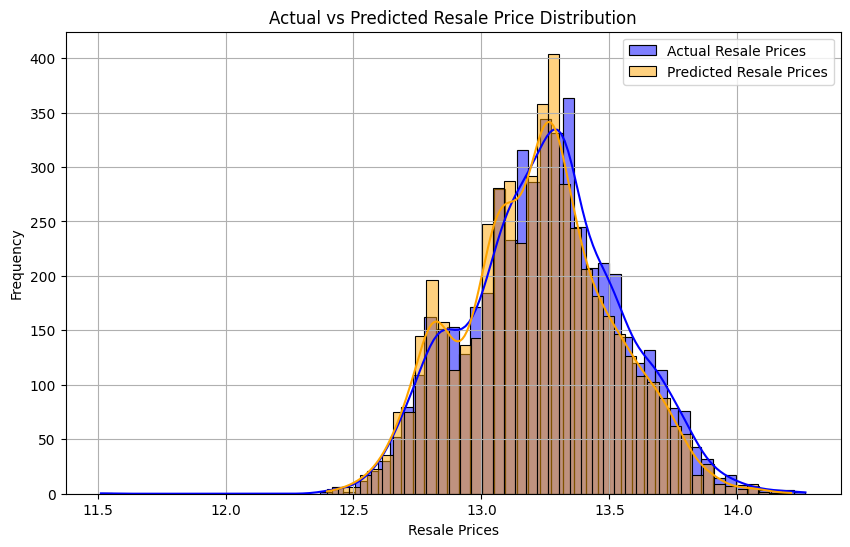

In [50]:
plt.figure(figsize=(10, 6))
sns.histplot(y_test, color='blue', alpha=0.5, label='Actual Resale Prices', kde=True)
sns.histplot(y_pred, color='orange', alpha=0.5, label='Predicted Resale Prices', kde=True)
plt.xlabel("Resale Prices")
plt.ylabel("Frequency")
plt.title("Actual vs Predicted Resale Price Distribution")
plt.legend()
plt.grid(True)
plt.show()

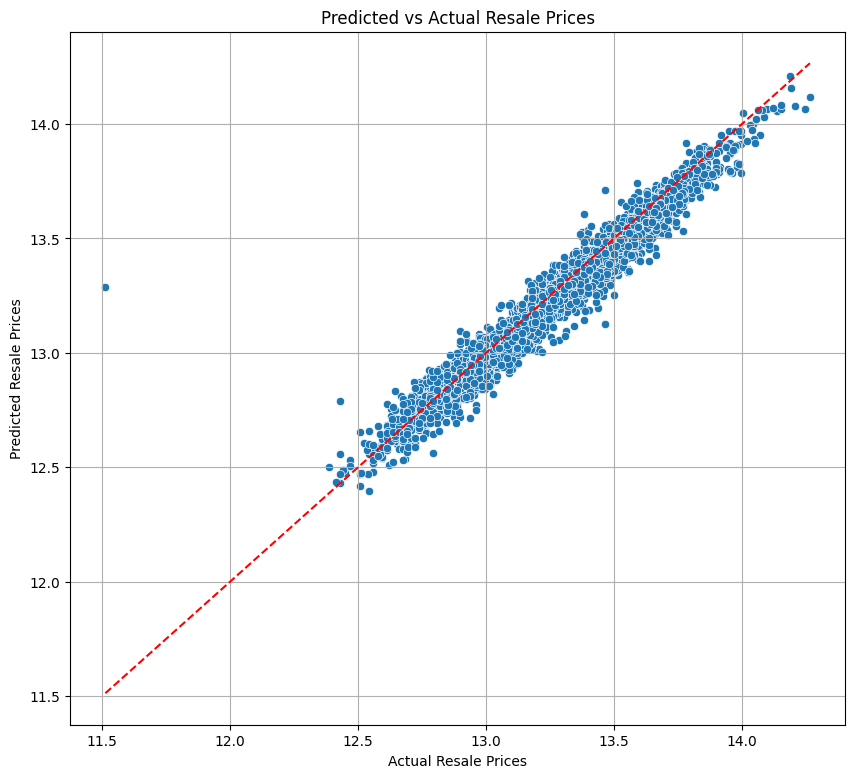

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 9))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
plt.xlabel("Actual Resale Prices")
plt.ylabel("Predicted Resale Prices")
plt.title("Predicted vs Actual Resale Prices")
plt.grid(True)
plt.show()